In [28]:
# PyAWD - AcousticWaveDataset
# Tribel Pascal - pascal.tribel@ulb.be

import numpy as np
import devito as dvt
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm

from PyAWD.GenerateVideo import generate_video
from PyAWD.utils import *
from PyAWD.Marmousi import *

dvt.logger.set_log_level('WARNING')

def solve_pde(grid, nx, ndt, ddt, epicenter, velocity_model):
    """
    Solves the Acoustic Wave Equation for the input parameters
    Arguments:
        - grid: a Devito Grid Object
        - nx: the discretization size of the array
        - ndt: the number of iteration for which the result is stored
        - ddt: the time step used for the Operator solving iterations
        - epicenter: the epicenter of the Ricker Wavelet at the beginning of the simulation
        - velocity_model: the velocity field across which the wave propagates
    Returns:
        - u: a Devito TimeFunction containing the solutions for the `ndt` steps
    """
    u = dvt.TimeFunction(name='u', grid=grid, space_order=2, save=ndt, time_order=2)
    u.data[:] = get_ricker_wavelet(nx, x0=epicenter[0], y0=epicenter[1])
    eq = dvt.Eq(u.dt2, (velocity_model**2)*(u.dx2+u.dy2))
    stencil = dvt.solve(eq, u.forward)
    op = dvt.Operator(dvt.Eq(u.forward, stencil), opt='noop')
    op.apply(dt=ddt)
    return np.array(u.data)

class AcousticWaveDataset(torch.utils.data.Dataset):
    """
    A Pytorch dataset containing acoustic waves propagating in the Marmousi velocity field.
    Arguments:
        - size: the number of samples to generate in the dataset
        - nx: the discretization size of the array (maximum size is currently 955)
        - sx: the sub-scaling factor of the array (0.5 means 1/2 values are returned)
        - ddt: the time step used for the Operator solving iterations
        - dt: the time step used for storing the wave propagation step (this should be higher than ddt)
        - t: the simulations duration
    """
    def __init__(self, size, nx=128, sx=1., ddt=0.01, dt=2, t=10, interrogators=[(0, 0)]):
        try:
            if dt < ddt:
                raise ValueError('dt should be >= ddt')
            self.size = size
            self.nx = min(nx, 955)
            self.sx = sx
            self.ddt = ddt
            self.dt = dt
            self.nt = int(t/self.dt)
            self.ndt = int(self.nt*(self.dt/self.ddt))
            self.interrogators = interrogators
            
            self.grid = dvt.Grid(shape=(self.nx, self.nx), extent=(1., 1.))
            self.velocity_model = dvt.Function(name='c', grid=self.grid)
            self.velocity_model.data[:] = Marmousi(self.nx).get_data()
    
            self.epicenters = np.random.randint(-self.nx//2, self.nx//2, size=(self.size, 2)).reshape((self.size, 2))
            self.generate_data()

            self.cmap = get_black_cmap()
            
        except ValueError as err:
            print(err)

    def generate_data(self):
        """
        Generates the dataset content by solving the Acoustic Wave PDE for each of the `epicenters`
        """
        self.data = []
        self.interrogators_data = {}
        for i in tqdm(range(self.size)):
            data = solve_pde(self.grid, self.nx, self.ndt, self.ddt, self.epicenters[i], self.velocity_model)
            self.data.append(data[::int(self.ndt/self.nt)])
            for interrogator in self.interrogators:
                self.interrogators_data[interrogator] = data[:, interrogator[0], interrogator[1]]
        self.data = np.array(self.data)

    def interrogate(self, point):
        """
        Returns the amplitude measurements for the interrogator at coordinates `point`. 
        Arguments:
            - point: the interrogator position as a Tuple
        """
        if point not in self.interrogators_data:
            print("Error: the interrogated point is not interrogable.")
            print("Available interrogable points:", list(self.interrogators_data.keys()))
        else:
            return self.interrogators_data[point]

    def plot_item(self, idx):
        """
        Plots the simulation of the idx^th sample
        Arguments:
            - idx: the number of the sample to plot
        """
        epicenter, item = self[idx]
        fig, ax = plt.subplots(1, self.nt, figsize=(self.nt*3, 3))
        for i in range(self.nt):
            ax[i].imshow(self.velocity_model.data[::int(1/self.sx), ::int(1/self.sx)], vmin=np.min(self.velocity_model.data[::int(1/self.sx), ::int(1/self.sx)]), vmax=np.max(self.velocity_model.data[::int(1/self.sx), ::int(1/self.sx)]), cmap="gray")
            x = ax[i].imshow(item[i*(item.shape[0]//self.nt)], 
                             vmin=-np.max(np.abs(item[i*(item.shape[0]//self.nt):])), 
                             vmax=np.max(np.abs(item[i*(item.shape[0]//self.nt):])), 
                             cmap=self.cmap)
            ax[i].set_title("t = " + str(i*(item.shape[0]//self.nt)*self.dt) + "s")
            ax[i].axis("off")
            fig.colorbar(x)
        plt.tight_layout()
        plt.show()

    def generate_video(self, idx, filename, nb_images):
        """
        Generates a video representing the simulation of the idx^th sample propagation
        Arguments:
            - idx: the number of the sample to simulate in the video
            - filename: the name of the video output file (without extension)
                        The video will be stored in a file called `filename`.mp4
            - nb_images: the number of frames used to generate the video
        """
        u = solve_pde(self.grid, self.nx, self.ndt, self.ddt, self.epicenters[idx], self.velocity_model)
        generate_video(u[::self.ndt//(nb_images)], filename, dt=self.ndt*self.ddt/(nb_images), c=self.velocity_model, verbose=True)

    def set_scaling_factor(self, sx):
        """
        Fixes a new scaling factor (0.5 means 1/2 values are returned). It should be <= 1.
        Arguments:
            - sx: the new scaling factor
        """
        if sx <= 1.:
            self.sx = sx
        else:
            print("The scaling factor should be lower or equal to 1.")
            
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.epicenters[idx], self.data[idx][:, ::int(1/self.sx), ::int(1/self.sx)]

In [29]:
a  = AcousticWaveDataset(10, interrogators=[(-10, 0), (10, 0), (0, -10), (0, 10)])

  0%|          | 0/10 [00:00<?, ?it/s]

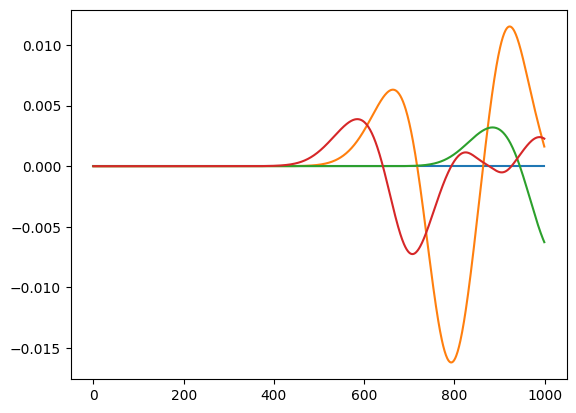

In [33]:
plt.plot(a.interrogate((-10, 0)))
plt.plot(a.interrogate((10, 0)))
plt.plot(a.interrogate((0, -10)))
plt.plot(a.interrogate((0, 10)))